Import the relevant packages:

In [1]:
import numpy as np

In [2]:
%cd /home/mike/Documents/Mars/3D_planetary_RT_model/python
%bookmark corona_model
from py_corona_sim import Pyobservation_fit

/home/mike/Documents/Mars/3D_planetary_RT_model/python


In [3]:
import idl_colorbars

In [4]:
from scipy.spatial.transform import Rotation as R

In [5]:
posdir=np.array([0,-1,0])
posdir=posdir/np.linalg.norm(posdir)
pos=10*3395e5*posdir

right_dir=np.array([1,0,0])
up_dir=np.cross(posdir,right_dir)
up_dir=up_dir/np.linalg.norm(up_dir)
right_dir=-np.cross(posdir,up_dir)
right_dir=right_dir/np.linalg.norm(right_dir)

center_dir=-posdir
angle=60
npix=600
lookangles=np.linspace(-angle*np.pi/180.,angle*np.pi/180.,npix)

In [6]:
def lookdir(az,ax):
    angle1=R.from_rotvec(-az*up_dir).as_matrix()
    angle2=R.from_rotvec(ax*right_dir).as_matrix()
    return np.array([*map(lambda x:np.matmul(x,center_dir),
                          [*map(np.matmul,angle1,angle2)])])


In [7]:
anglepairs=np.array([([ax],[az]) for az in lookangles for ax in lookangles])
all_lookangles=lookdir(anglepairs[:,0],anglepairs[:,1])
all_pos = np.array([pos for i in all_lookangles])

In [8]:
pycorona = Pyobservation_fit()
pycorona.add_observation(all_pos,all_lookangles)
pycorona.set_g_factor([1.22848e-3,2.52e-6])

In [15]:
%time pycorona.generate_source_function(5.5e5,200)
%time brightness = pycorona.brightness()

CPU times: user 179 ms, sys: 567 µs, total: 180 ms
Wall time: 179 ms
CPU times: user 294 ms, sys: 11.8 ms, total: 306 ms
Wall time: 304 ms


In [10]:
absorption = np.exp(-np.where(pycorona.tau_absorber_final() == -1, 1e5, pycorona.tau_absorber_final()))

In [11]:
np.max(absorption*pycorona.tau_species_final(),axis=1)

array([104.04031678])

In [12]:
brightness.max()

9.358509063720703

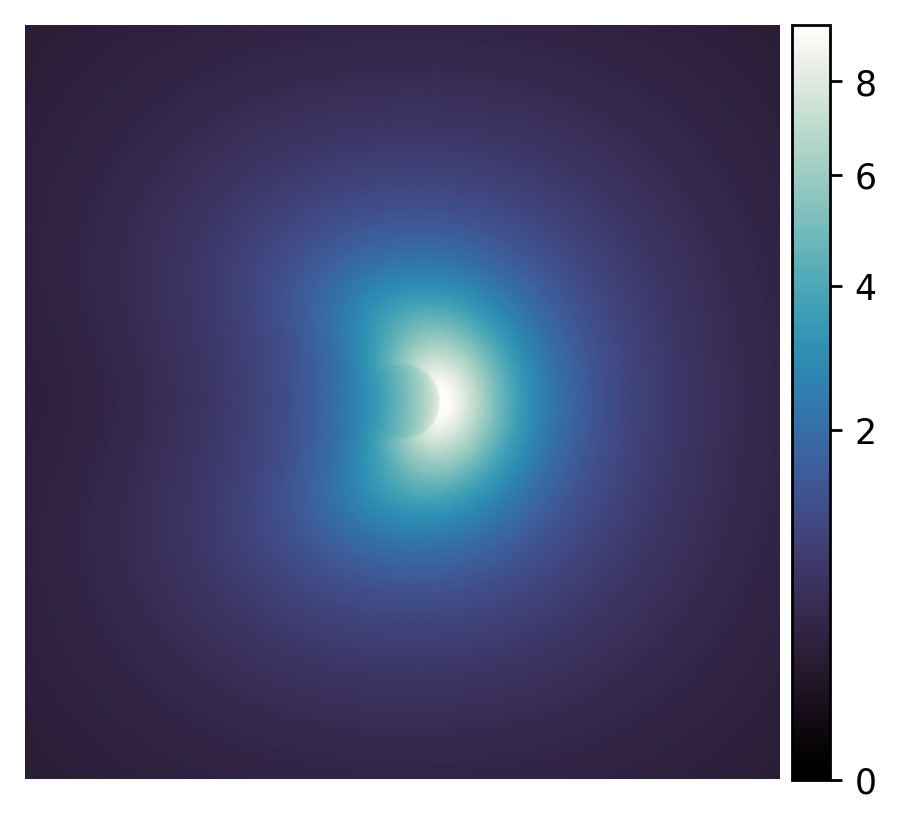

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
from matplotlib.colors import LogNorm,PowerNorm
# C = some matrix
f, ax = plt.subplots(1,dpi=250)

import copy
my_cmap = copy.copy(idl_colorbars.getcmap(109)) # copy the default cmap
my_cmap.set_bad((0,0,0))

im = ax.imshow(brightness[0].reshape((npix,npix)), cmap=my_cmap, norm=PowerNorm(0.5,vmin=0.0, vmax=brightness.max(), clip=True))
t = [0,5,10,15,20]
#im = ax.imshow(brightness.reshape((npix,npix)), cmap=my_cmap, norm=LogNorm(vmin=0.1, vmax=20, clip=True))
#t = [0.1,0.5,1,5,10,20]

ax.set_axis_off()

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(im, cax=cax)#, ticks=t, format='$%.2f$');

This will plot Lyman beta if observation_fit computes it:

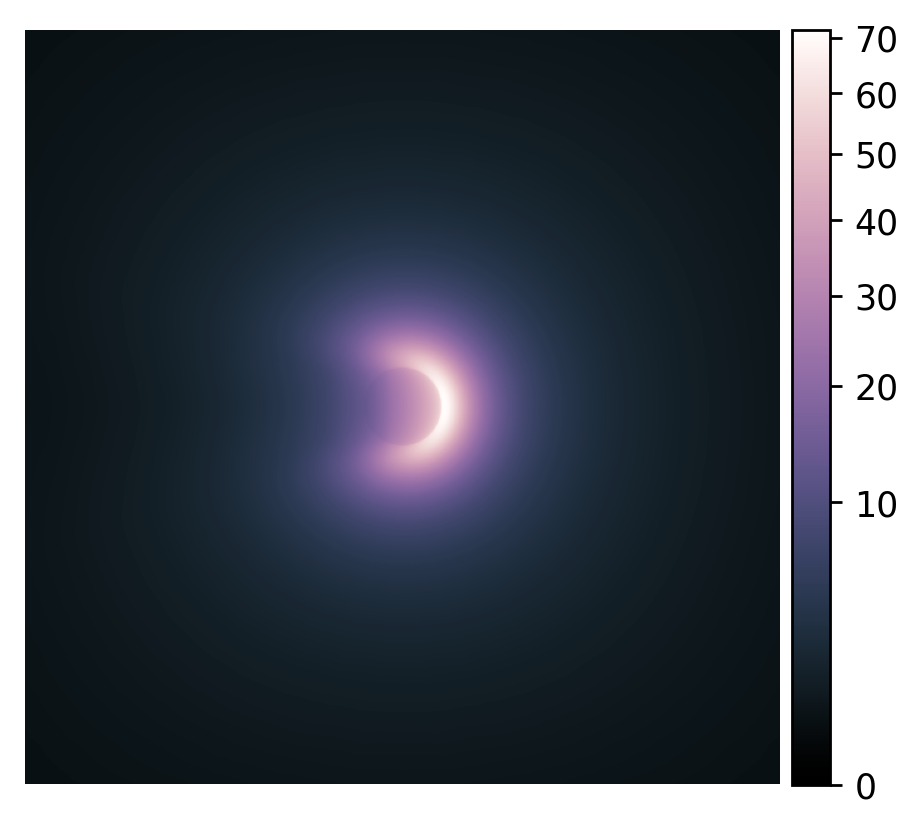

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
from matplotlib.colors import LogNorm,PowerNorm
# C = some matrix
f, ax = plt.subplots(dpi=250)

import copy
my_cmap = copy.copy(idl_colorbars.getcmap(114)) # copy the default cmap
my_cmap.set_bad((0,0,0))

im = ax.imshow(brightness[1].reshape((npix,npix))*1000, cmap=my_cmap, norm=PowerNorm(0.5,vmin=0.0, vmax=1000*brightness[1].max(), clip=True))
#t = [0,50,100]
#im = ax.imshow(brightness.reshape((npix,npix)), cmap=my_cmap, norm=LogNorm(vmin=0.1, vmax=20, clip=True))
#t = [0.1,0.5,1,5,10,20]

ax.set_axis_off()

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(im, cax=cax)#, ticks=t, format='$%.2f$');